Step 1: This file should be located in a directory which is in the same directory as zemax   
Step 2: Go to zemax, go to programming tab, zos-api.net..., python, interactive extension. This will create the zos connection file.      
Step 3: Click Interactive Extension

Below I show the setup before it has been optimised. It is a 4f system, for some reason not perfectly symmetric. In this notebook I will optimise the lens on the right to maximize the MTF.

![image](pics/4f_no_optimised.PNG)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from helper import *

import os 
import sys
import h5py
path = os.path.dirname(os.path.dirname(os.path.realpath("__file__")))


# sys.path.append(path)
sys.path.insert(0,path)
# zemax_path = path+"\Zemax\ZOS-API Projects\PythonZOSConnection\PythonZOSConnection.py" # work this out later


This initializes the connection.

In [3]:
%run -i "\\alfs1.physics.ox.ac.uk\al\howards\Zemax\ZOS-API Projects\PythonZOSConnection\PythonZOSConnection.py"

Found OpticStudio at:   %sc:\program files\zemax opticstudio
Connected to OpticStudio
Serial #:  L121911


First lets look at what the MTF of the system looks like before optimisation

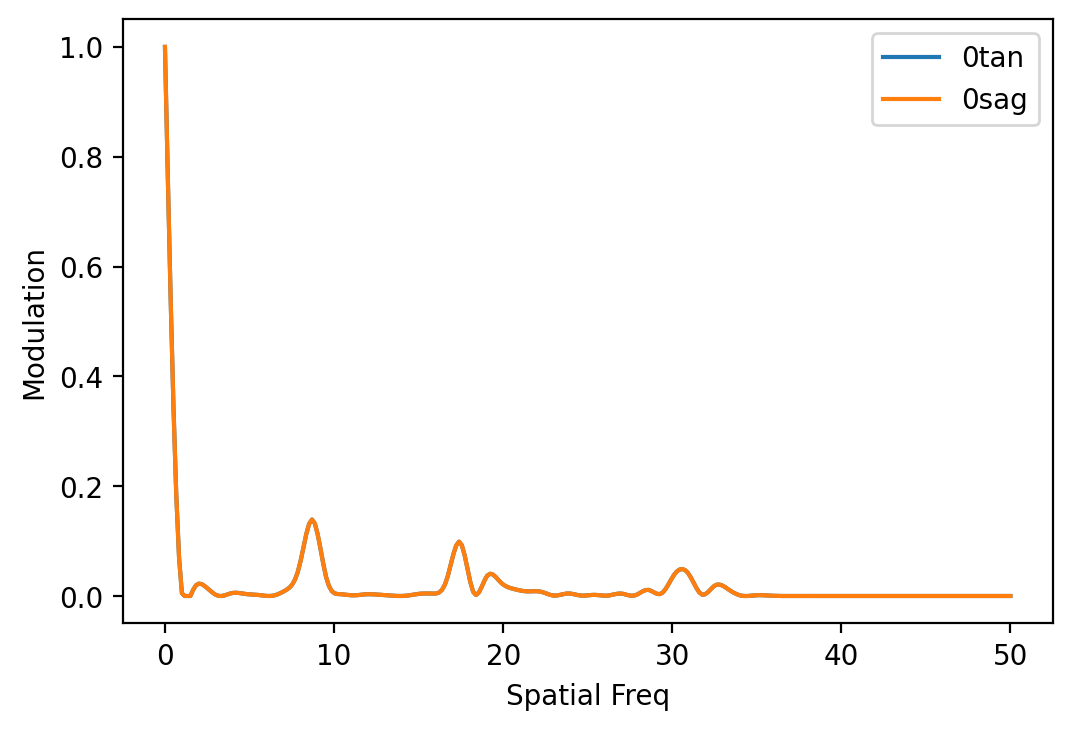

In [4]:
analyse_MTF(TheSystem,ZOSAPI,50)

And now lets get ready to optimise...

In [5]:
LDE = TheSystem.LDE #Lens properties contained in LDE (Lens Data Editor).

print(LDE.NumberOfSurfaces) #surface 4 is the lens we wish to optimise 

variable_lens = LDE.GetSurfaceAt(4) #I think index begins at 1

variable_lens.RadiusCell.MakeSolveVariable()
variable_lens.ThicknessCell.MakeSolveVariable()



7


True

In [6]:
#make merit function...
MFE = TheSystem.MFE
OptWizard = MFE.SEQOptimizationWizard

#lets make 4 optimisation variables for MTF at different frequencies.
freqs = [10,30,50,70]
for i in range(1,5):
    Merit = MFE.GetOperandAt(i) 
    Merit.ChangeType(ZOSAPI.Editors.MFE.MeritOperandType.MTFN)
    Merit.Target = 1.0
    Merit.Weight = 1.0
    Merit.GetCellAt(5).DoubleValue = 30


OptWizard.IsGlassUsed = True
OptWizard.GlassMin = 1.0
OptWizard.GlassMax = 5.0
OptWizard.GlassEdge = 3.0
OptWizard.IsAirUsed = False
OptWizard.Apply()



In [7]:

print('Running Local Optimization')
LocalOpt = TheSystem.Tools.OpenLocalOptimization()
LocalOpt.Algorithm = ZOSAPI.Tools.Optimization.OptimizationAlgorithm.DampedLeastSquares
LocalOpt.Cycles = ZOSAPI.Tools.Optimization.OptimizationCycles.Automatic
LocalOpt.NumberOfCores = 8
LocalOpt.RunAndWaitForCompletion()
LocalOpt.Close()


Running Local Optimization


True

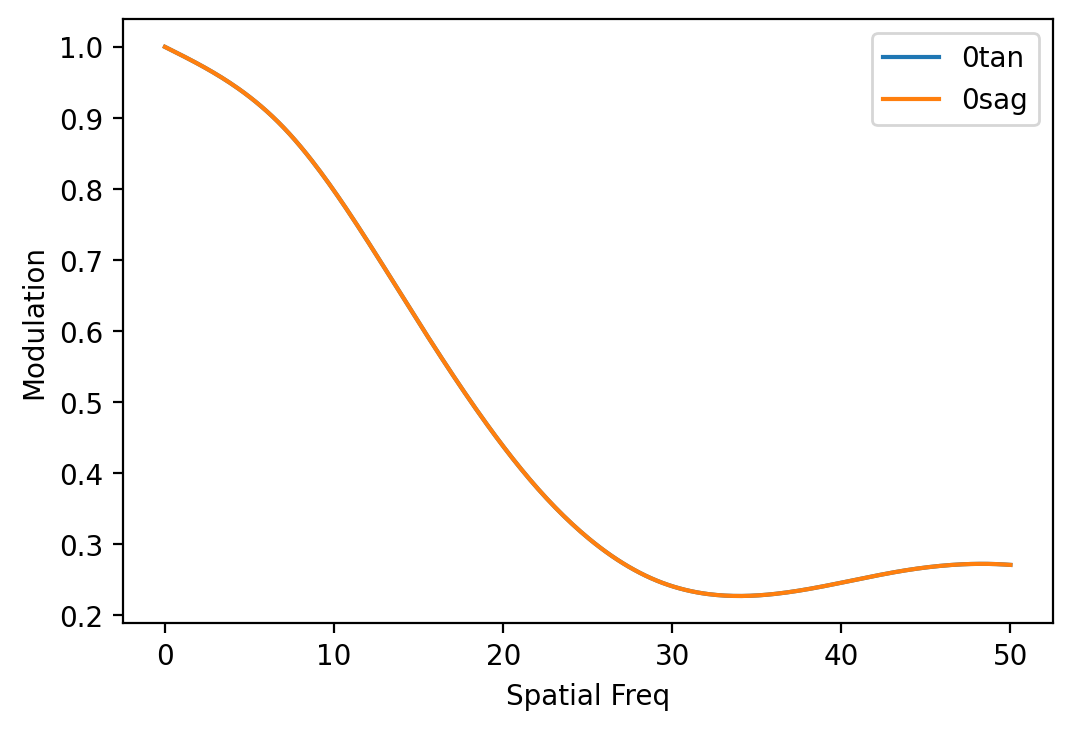

In [8]:
analyse_MTF(TheSystem,ZOSAPI,50)

Lets see what the final setup looks like...

![image](pics/4f_optimised.PNG)